In [58]:
%matplotlib inline

# imports
import pandas as pd
from torchvision.io import read_image, ImageReadMode
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [59]:
# const

#DIR_PATH = "../dataset/brain-tumor-mri"
DIR_PATH = "C:\\Users\\elena\\Desktop\\universidad\\3º año\\FSI\\pythorch\\notes\\brain-tumor-mri-dataset"

LABELS = ["notumor", "glioma", "meningioma", "pituitary"]

TRAIN_PERCENT = .7
VAL_PERCENT = .2
TEST_PERCENT = .1

IMAGE_SIZE = 220

RANDOM_STATE = None

BATCH_SIZE = 20
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
NUM_EPOCH = 200
EARLY_PATIENCE = 10
SCHEDULER_PATIENCE = 6

# Data Manipulation

In [60]:
# creamos un dataset de la forma (path, class)
dataset = pd.DataFrame(columns = ["path", "label"])


for dir in os.listdir(DIR_PATH):
    for label in os.listdir(os.path.join(DIR_PATH, dir)):
        for img in os.listdir(os.path.join(DIR_PATH, dir, label)):
            dataset.loc[len(dataset)] = {"path": os.path.join(DIR_PATH, dir, label, img),
                                   "label": LABELS.index(label) }


print("num elementos:", dataset.count(axis=1).size)
print(dataset.head())

num elementos: 7023
                                                path  label
0  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
1  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
2  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
3  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1
4  C:\Users\elena\Desktop\universidad\3º año\FSI\...      1


In [61]:
min_cat_size = dataset.label.value_counts().min()

print("> Cantidad de imagenes de la categoria que menos tiene:", min_cat_size)

> Cantidad de imagenes de la categoria que menos tiene: 1621


In [62]:
# Hacemos que todos tengan los mismos elementos
dataset = pd.DataFrame(dataset.groupby("label").apply(lambda label: label.sample(min_cat_size, random_state=RANDOM_STATE)).reset_index(drop=True))

print("> Cantidad de elementos: ", dataset.count(axis=1).size)
print(dataset.label.value_counts())
print(dataset.head())

> Cantidad de elementos:  6484
label
0    1621
1    1621
2    1621
3    1621
Name: count, dtype: int64
                                                path  label
0  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
1  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
2  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
3  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0
4  C:\Users\elena\Desktop\universidad\3º año\FSI\...      0


In [63]:
# separamos en los cjtos de entrenamiento
train_dataset, tmp = train_test_split(dataset, train_size=TRAIN_PERCENT, stratify=dataset["label"], shuffle=True, random_state=RANDOM_STATE)
val_dataset, test_dataset = train_test_split(tmp, test_size=TEST_PERCENT/(TEST_PERCENT+VAL_PERCENT), stratify=tmp["label"], shuffle=True, random_state=RANDOM_STATE)

print("> train", train_dataset.count(axis=1).size, train_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(train_dataset.label.value_counts())
print()

print("> val", val_dataset.count(axis=1).size, val_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(val_dataset.label.value_counts())
print()

print("> test", test_dataset.count(axis=1).size, test_dataset.count(axis=1).size/dataset.count(axis=1).size)
print(test_dataset.label.value_counts())
print()

> train 4538 0.6998766193707588
label
0    1135
2    1135
1    1134
3    1134
Name: count, dtype: int64

> val 1297 0.2000308451573103
label
1    325
2    324
0    324
3    324
Name: count, dtype: int64

> test 649 0.10009253547193091
label
3    163
1    162
2    162
0    162
Name: count, dtype: int64


In [64]:
# Comprobamos que son disjuntos
print((train_dataset[ "path" ].isin(test_dataset["path"] ) == True).value_counts())
print((train_dataset[ "path" ].isin(val_dataset["path"] ) == True).value_counts())
print((val_dataset[ "path" ].isin(test_dataset["path"]) == True).value_counts())

path
False    4538
Name: count, dtype: int64
path
False    4538
Name: count, dtype: int64
path
False    1297
Name: count, dtype: int64


# Preparations

## Classes

In [65]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.dataframe.count(axis=1).size
    
    def __getitem__(self, idx) -> (str, int):
        
        row = self.dataframe.iloc[idx]
        img, label = row.path, row.label

        img = read_image(img, mode=ImageReadMode.GRAY)
        if self.transform: img = self.transform(img)

        return img, label

In [66]:
class EarlyStopper:
    
    def __init__(self, patience=5, min_delta=0, callback=lambda **_: None):
        self.patience = patience
        self.min_delta = min_delta
        self.callback = callback

        self.counter = 1

        self.best_model = None
        self.best_loss = float("inf")

    def __call__(self, val_loss, model):

        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0

            self.best_model = model.state_dict()
            return False


        self.counter += 1
        if self.counter >= self.patience:
            self.callback(counter=self.counter, best_loss=self.best_loss, best_model=self.best_model)
            return True

    def reset(self):
        self.early_stop = False
        self.counter = 1

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layer 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, padding='same')
        self.bn1 = nn.BatchNorm2d(64)

        # Convolutional layer 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, padding='same')
        self.bn2 = nn.BatchNorm2d(128)

        # Convolutional layer 3
        self.conv3 = nn.Conv2d(128, 128, kernel_size=7, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        # Convolutional layer 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=7, padding='same')
        self.bn4 = nn.BatchNorm2d(256)

        # Convolutional layer 5
        self.conv5 = nn.Conv2d(256, 256, kernel_size=7, padding='same')
        self.bn5 = nn.BatchNorm2d(256)

        # Convolutional layer 6
        self.conv6 = nn.Conv2d(256, 512, kernel_size=7, padding='same')
        self.bn6 = nn.BatchNorm2d(512)

        # Fully connected layers
        self.fc1 = nn.Linear(4608, 1024)  # Dimension might need adjustment
        self.dropout1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(512, 4)

    def forward(self, x):
        # Convolutional layers with ReLU activations and batch normalization
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, kernel_size=2)

        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No activation, as this will be included in the loss function

        return x


## Functions

In [68]:
def eval(model, loader, *, device = None, criterion = None):
    """returns pred, real, accuracy, val_loss"""
    if not (device and criterion): raise Exception("Params needed")

    model.eval()

    corrects = 0

    pred = []
    real = []
    loss = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            
            imgs, labels = imgs.to(device), labels.to(device)

            outs = model(imgs)
            loss += criterion(outs.data, labels).item()

            _, predicted = torch.max(outs.data, 1)
            
            total += labels.size(0)
            pred.extend(predicted.tolist())
            real.extend(labels.tolist())

            corrects += (predicted == labels).sum().item()
    
    return  pred, real, loss/len(loader), corrects/total

In [69]:
def train_loop(model, loader, *, optimizer, criterion, num_epoch=100, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), train_loss_h=[], train_acc_h=[], val_loss_h=[] ,val_acc_h=[], callback=lambda **_: None, early_callback=lambda **_: None, scheduler, val_loader):
    if not (optimizer and criterion and early_stopper and scheduler): raise Exception("Params needed")
    
    val_preds, val_labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
    callback(epoch=0, val_acc=val_acc, val_loss=val_loss, train_loss=float("inf"), train_acc=0)

    for epoch in range(num_epoch):

        running_loss = 0.0
        corrects = 0
        total = 0

        model.train()

        for i, (imgs, labels) in enumerate(loader, 1):

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outs = model(imgs)
            loss = criterion(outs, labels)
            
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            # extra for analytics
            _, predicted = torch.max(outs, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()
            # ==================

            if not i % 10:
                print(f"\tEpoch {epoch+1}, Batch {i}: Loss: {running_loss*(len(loader)-i+1)/(10*len(loader)):.4f}")
            
        val_preds, val_labels, val_loss, val_acc  = eval(model, val_loader, device=device, criterion=criterion)
        scheduler.step(val_loss)
        
        # extra for analytics
        train_loss = running_loss/len(loader)
        train_loss_h.append(train_loss)
        train_acc = 100*corrects/total
        train_acc_h.append(train_acc)

        val_loss_h.append(val_loss)
        val_acc_h.append(val_acc*100)
        # ===================

        callback(epoch=epoch+1, val_acc=val_acc, val_loss=val_loss, train_loss=train_loss, train_acc=train_acc)

        if(early_stopper(val_loss, model)): break

    return train_acc_h, val_acc_h, train_loss_h, val_loss_h, val_preds, val_labels

# Utils

In [70]:
def save_model(model, path, complete=False):
    try:
        torch.save(model if complete else model.state_dict(), path)
    except Exception as e:
        print("Error al guardar el model:", e)

In [71]:
def show_img(img, label):
    print('Label: ', dataset.label[label], "(" + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

## Dataset statistics

In [72]:
unnormalized_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.ToTensor()
])

unnormalized_dataset = CustomDataset(dataset, transform=unnormalized_transforms)
loader = DataLoader(unnormalized_dataset, batch_size=1, shuffle=False)

sum_intensity = 0.0
sum_squared_intensity = 0.0
n_samples = 0

for imgs, _ in loader:
    
    sum_intensity += imgs.sum()
    sum_squared_intensity += (imgs ** 2).sum()
    n_samples += imgs.numel()

mean = sum_intensity / n_samples
std = torch.sqrt(sum_squared_intensity / n_samples - mean ** 2)

print(mean)
print(std)

tensor(0.1838)
tensor(0.1990)


In [73]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
    transforms.RandomRotation(180),            
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


train_dataset = CustomDataset(train_dataset, transform=train_transform)
val_dataset = CustomDataset(val_dataset, transform=test_valid_transforms)
test_dataset = CustomDataset(test_dataset, transform=test_valid_transforms)

# Acceder e imprimir las primeras 5 muestras del dataset
for i in range(5):
    image, label = train_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")
    image, label = val_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")
    image, label = test_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")

# Imprimir los valores de la media y la desviación estándar
print(f"Media: {mean}, Desviación Estándar: {std}")

Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 0
Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 2
Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 1
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 2
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 2
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 1
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 2
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 0
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 3
Muestra 3: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([1, 220, 220]), Etiqueta - 1
Muestra 3: Imagen - 

Batch de imágenes: torch.Size([20, 1, 220, 220]), Batch de etiquetas: torch.Size([20])
Label:  0 (0)


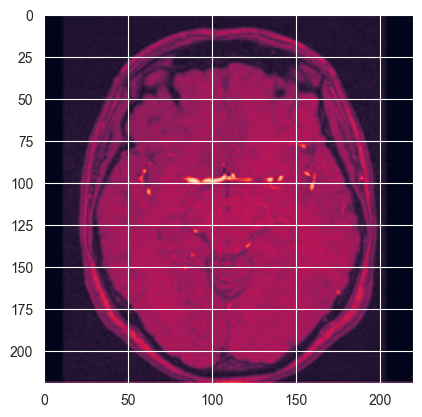

In [74]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Verificar DataLoader
for images, labels in train_loader:
    print(f"Batch de imágenes: {images.shape}, Batch de etiquetas: {labels.shape}")
    break

# Carga una imagen de prueba
img, label = test_dataset[45]
show_img(img, label)

## Comprobaciones previas de la GPU

In [75]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para usar: {device}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.1.2+cu121
Dispositivo configurado para usar: cuda
True
NVIDIA GeForce RTX 2060


## Entrenamos

In [76]:
def early_callback(**kwargs): print("> Early stopping <")

early_stopper = EarlyStopper(patience=EARLY_PATIENCE, min_delta=.001, callback=early_callback)

In [77]:


model = CNN()
if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=SCHEDULER_PATIENCE, verbose=True)

def callback(**kwargs):
    print(f"Epoch: {kwargs['epoch']}, val_loss: {(kwargs['val_loss']):.2f}, train_loss: {(kwargs['train_loss']):.2f} val_acc: {(kwargs['val_acc']*100):.2f}, train_acc: {(kwargs['train_acc']):.2f}")

train_acc_h, val_acc_h, train_loss_h, val_loss_h, preds, targets = train_loop(model, train_loader,
           val_loader=val_loader,                                                             
           optimizer=optimizer,
           criterion=criterion,
           num_epoch=NUM_EPOCH,
           device=device,
           callback=callback,
           scheduler=scheduler
           )

Epoch: 0, val_loss: 1.39, train_loss: inf val_acc: 24.98, train_acc: 0.00
	Epoch 1, Batch 10: Loss: 1.3314
	Epoch 1, Batch 20: Loss: 2.4978
	Epoch 1, Batch 30: Loss: 3.4979
	Epoch 1, Batch 40: Loss: 4.3548
	Epoch 1, Batch 50: Loss: 5.0970
	Epoch 1, Batch 60: Loss: 5.6901
	Epoch 1, Batch 70: Loss: 6.2044
	Epoch 1, Batch 80: Loss: 6.5348
	Epoch 1, Batch 90: Loss: 6.8013
	Epoch 1, Batch 100: Loss: 6.9249
	Epoch 1, Batch 110: Loss: 6.9652
	Epoch 1, Batch 120: Loss: 6.8864
	Epoch 1, Batch 130: Loss: 6.7029
	Epoch 1, Batch 140: Loss: 6.4351
	Epoch 1, Batch 150: Loss: 6.0506
	Epoch 1, Batch 160: Loss: 5.5915
	Epoch 1, Batch 170: Loss: 5.0436
	Epoch 1, Batch 180: Loss: 4.3966
	Epoch 1, Batch 190: Loss: 3.6503
	Epoch 1, Batch 200: Loss: 2.8085
	Epoch 1, Batch 210: Loss: 1.8822
	Epoch 1, Batch 220: Loss: 0.8695
Epoch: 1, val_loss: 0.91, train_loss: 1.11 val_acc: 68.85, train_acc: 55.40
	Epoch 2, Batch 10: Loss: 0.9394
	Epoch 2, Batch 20: Loss: 1.7793
	Epoch 2, Batch 30: Loss: 2.5188
	Epoch 2, Ba

# Analizamos los datos

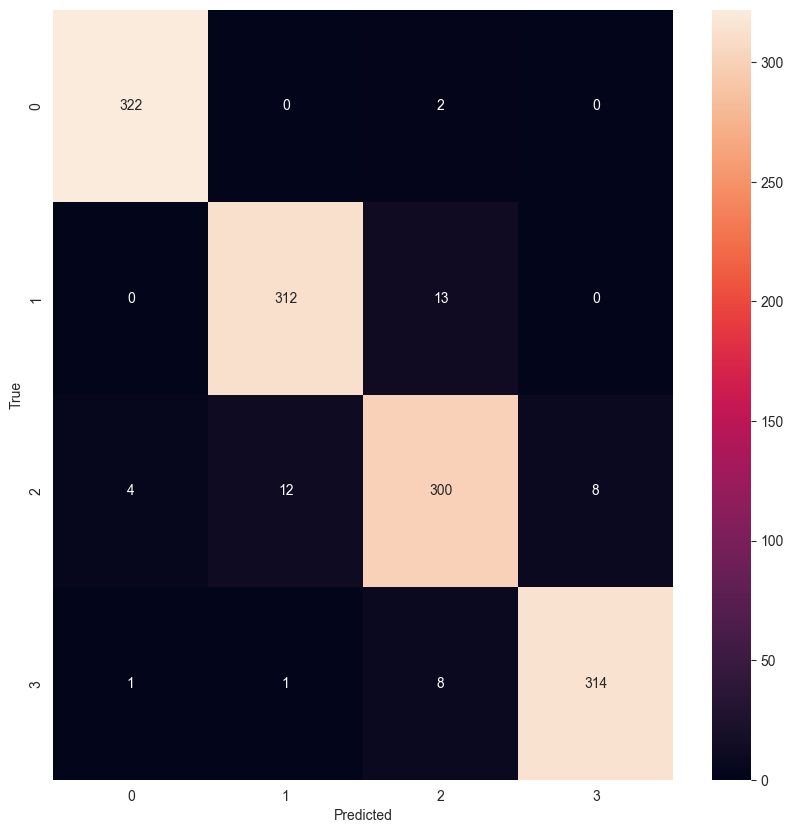

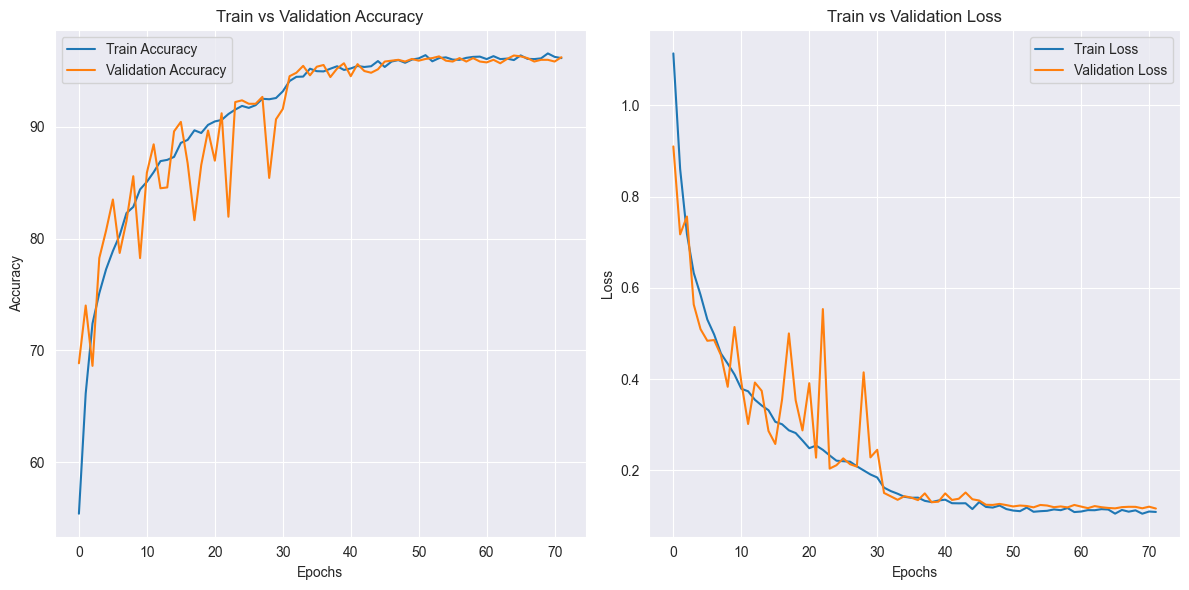

Train Dataset ----------------------------------------------------------------
train_loss: 0.08268400110173067 - train_acc: 0.9722344645218158
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1135
           1       0.97      0.96      0.97      1134
           2       0.96      0.94      0.95      1135
           3       0.98      0.99      0.99      1134

    accuracy                           0.97      4538
   macro avg       0.97      0.97      0.97      4538
weighted avg       0.97      0.97      0.97      4538
Val Dataset ----------------------------------------------------------------
val_loss: 0.11596334686932655 - val_acc: 0.9622205088666153
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       324
           1       0.96      0.96      0.96       325
           2       0.93      0.93      0.93       324
           3       0.98      0.97      0.97       324

    accuracy  

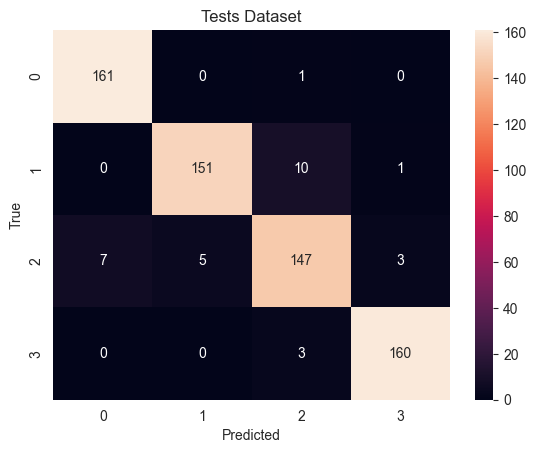

Tests Dataset ----------------------------------------------------------------
test_loss: 0.14533161030461392 - test_acc: 0.9537750385208013
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       162
           1       0.97      0.93      0.95       162
           2       0.91      0.91      0.91       162
           3       0.98      0.98      0.98       163

    accuracy                           0.95       649
   macro avg       0.95      0.95      0.95       649
weighted avg       0.95      0.95      0.95       649


In [78]:
model.load_state_dict(early_stopper.best_model)
model.eval()

cm = metrics.confusion_matrix(targets, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Gráfico de la precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc_h, label='Train Accuracy')
plt.plot(val_acc_h, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_loss_h, label='Train Loss')
plt.plot(val_loss_h, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# cjto train
train_preds, train_reals, train_loss, train_acc = eval(model, train_loader, device=device, criterion=criterion)
print("Train Dataset ----------------------------------------------------------------")
print(f"train_loss: {train_loss} - train_acc: {train_acc}")
print(metrics.classification_report(train_reals, train_preds, zero_division=0))


# cjto val
val_preds, val_reals, val_loss, val_acc = eval(model, val_loader, device=device, criterion=criterion)
print("Val Dataset ----------------------------------------------------------------")
print(f"val_loss: {val_loss} - val_acc: {val_acc}")
print(metrics.classification_report(val_reals, val_preds, zero_division=0))

# cjto tests
test_preds, test_reals, test_loss, test_acc = eval(model, test_loader, device=device, criterion=criterion)
cm = metrics.confusion_matrix(test_reals, test_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Tests Dataset")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Tests Dataset ----------------------------------------------------------------")
print(f"test_loss: {test_loss} - test_acc: {test_acc}")
print(metrics.classification_report(test_reals, test_preds, zero_division=0))

In [79]:
save_model(model, "/kaggle/working/model.pth", complete=True)

Error al guardar el model: Parent directory /kaggle/working does not exist.
